<a href="https://colab.research.google.com/github/sekhrianchal6/Arima/blob/main/Arima_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importing Dataset and library

In [2]:
#importing library for data preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
#importing library for training model and model validation
from sklearn.model_selection import train_test_split as split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/sekhrianchal6/Arima/main/Maternal%20Health%20Risk%20Data%20Set.csv')

In [4]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [5]:
df['RiskLevel'].replace({"high risk": "2", "mid risk": "1", "low risk" : "0"}, inplace=True)
df['RiskLevel'] = df['RiskLevel'].astype(float)
df.head(2)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2.0
1,35,140,90,13.0,98.0,70,2.0


#2. Basic Data Exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 55.6 KB


The dataset contains over **1014** entries and **7 columns** with no missing values

In [7]:
#check duplicates
duplicates = df.duplicated().sum()
print(f"The total number of duplicated rows in the dataset is {duplicates}")

The total number of duplicated rows in the dataset is 562


Duplicates in medical data entry are commons occurence, There can be a lot of patients with same data entries, so we won't be removing the duplicates, assuming the data provided is accurate.

In [8]:
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775,0.867850
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702,0.807353
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000,0.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000,0.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000,1.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000,2.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000,2.000000


* The average age of the reported pregnant patient in the dataset is about **29 years**
* The youngest reported patient in the dataset is **10 years**
* The oldest patient in the dataset is **70 years of age**
* The highest reported blood sugar level in the dataset is **19mm0l/L**
* The lowest Diastolic blood pressure in the dataset is **49mmHg**
* The lowest reported heart rate in the dataset is **7beats/min**
* The average systolic blood pressure in the dataset is about **113mmHg**





Just by taking a glance at dataset we can see unusual data entry with heart rate 7 and age with 10 years old. Seems like outliers, we will verify that using box plot later.

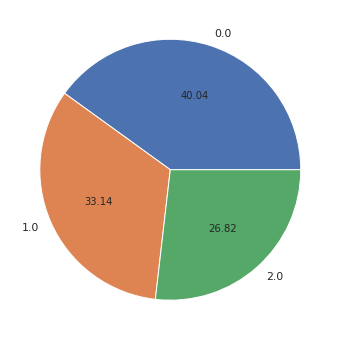

In [9]:
#Check the distributions of dataset on the basis of target features
Risk_level = df.RiskLevel.value_counts()
plt.figure(figsize=(8,6))
plt.pie(Risk_level.values, labels=Risk_level.index, autopct='%.2f')
plt.show()

Datasets are equally distributed among all risk levels, so we don't have a problem of skewed datasets. In this case we can use accuracy metrics to check the performance of our model.

# 3. Univariate and Bivariate Analysis

In [10]:
#Functions to plot distribution of each features with target variable
def plot_distrbution(df,column, hue= None):
    fig, axes =plt.subplots(1,3, figsize=(20,5))
    sns.kdeplot(data=df, x=column , shade=True, ax=axes[0], hue=hue)
    if(hue):
        sns.boxplot(data=df, x=hue, ax=axes[1],y=column)
    else:
        sns.boxplot(data=df, x=column, ax=axes[1] )
    sns.histplot(data=df, x=column , ax=axes[2],hue=hue)
    plt.suptitle(f'Distribution of the {column}')

#3.1 Univariate Distribution

In this univariate analysis we will take a closer look at each feature distribution separately and with the target variable.

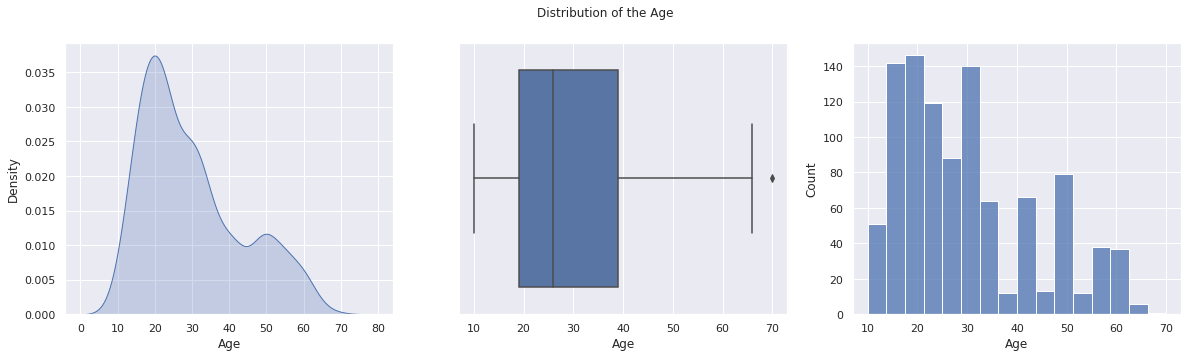

In [11]:
plot_distrbution(df=df, column='Age')

There seems like a outlier in the age column where the age is 70 yrs. But it is medically proven that women can get pregnant at the age 70 years too. Let's analyze further before calling it an outlier.

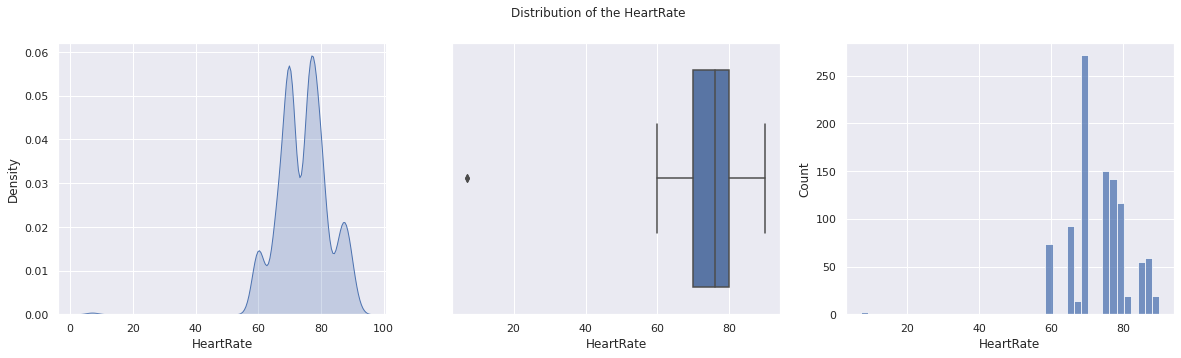

In [12]:
plot_distrbution(df=df, column='HeartRate')

The normal heart rate is between 60-120 bpm. Heart rate with 7bpm is definitely an outlier, we have to deal with this during our model training phase, Now let's do a bivariate analysis with the target variable to get a depth understanding of distribution of each feature.

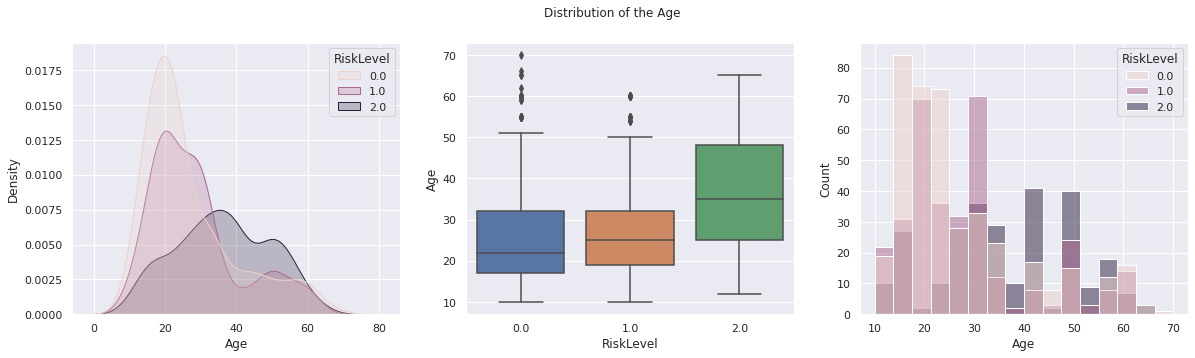

In [13]:
plot_distrbution(df=df, column='Age', hue='RiskLevel')

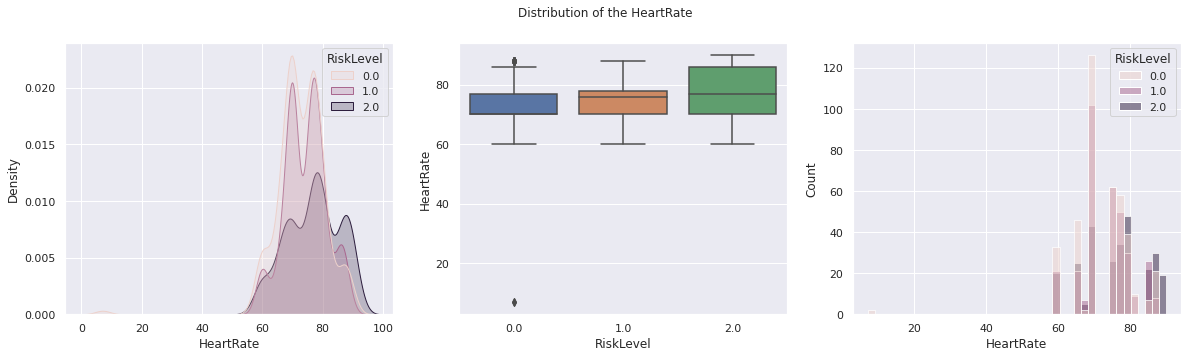

In [14]:
plot_distrbution(df=df, column='HeartRate', hue='RiskLevel')

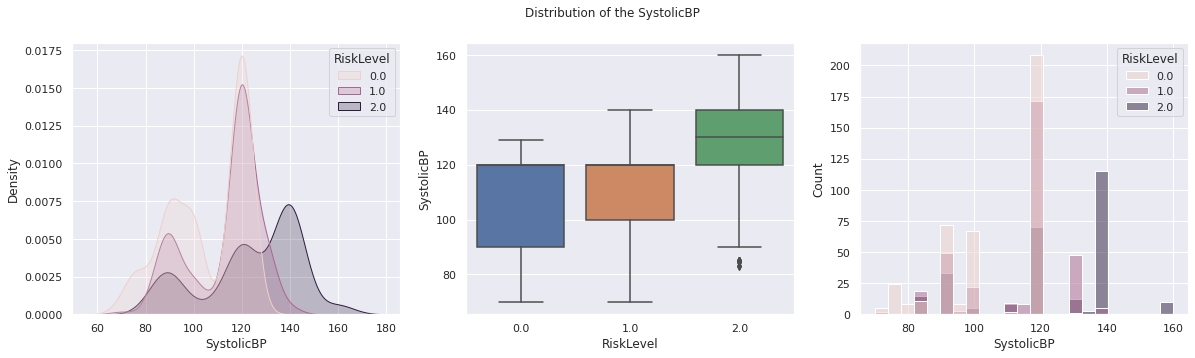

In [15]:
plot_distrbution(df=df, column='SystolicBP', hue='RiskLevel')

Pregnant women with high SystolicBP seems to have a high health risk, regardless of their age.

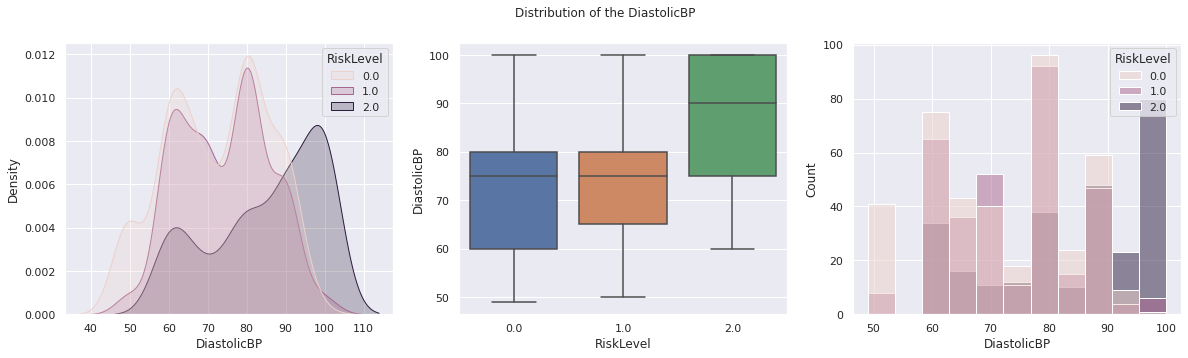

In [16]:
plot_distrbution(df=df, column='DiastolicBP', hue='RiskLevel')

Having low SystolicBP at a young age (under 50 years) doesn't guarantee does not guarantee our health risk is low, but it seems to have it in old age makes our health risks lower.

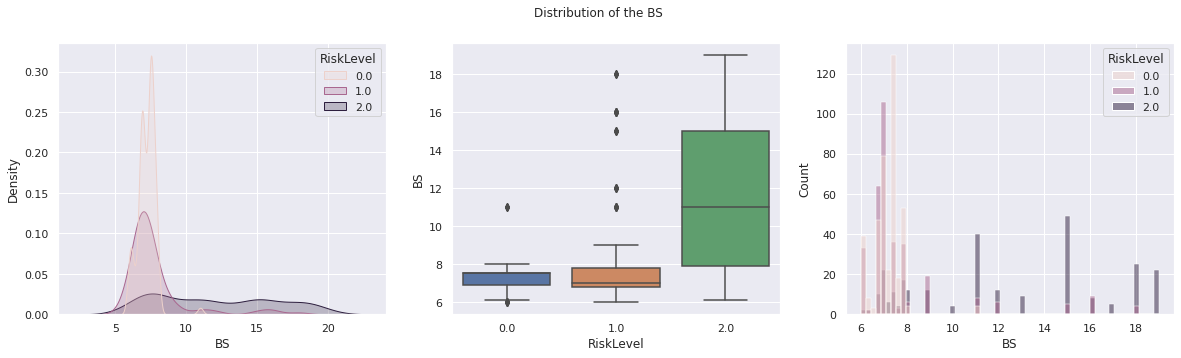

In [17]:
plot_distrbution(df=df, column='BS', hue='RiskLevel')

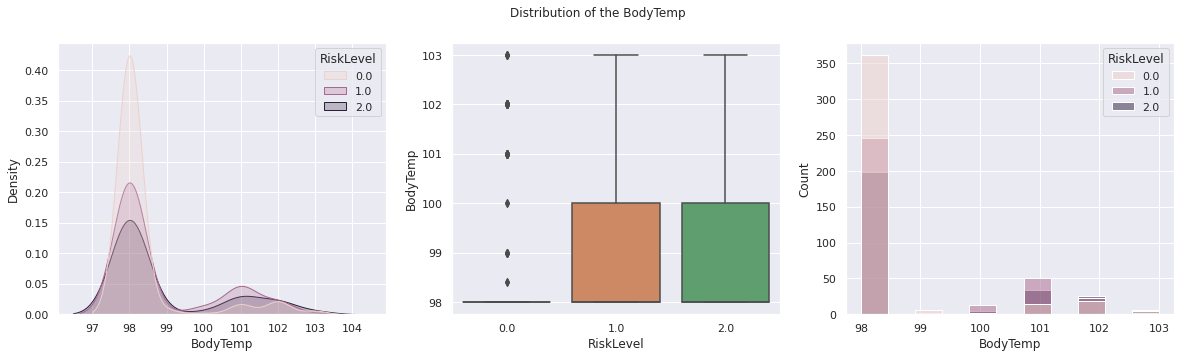

In [18]:

plot_distrbution(df=df, column='BodyTemp', hue='RiskLevel')

# 3.2 Bivariate Distribution

##3.2.1 Correlation Plot

We will use correlation plot to see how each feature are related with each other, if there is any multicollinearity we will remove one of the feature, lets check

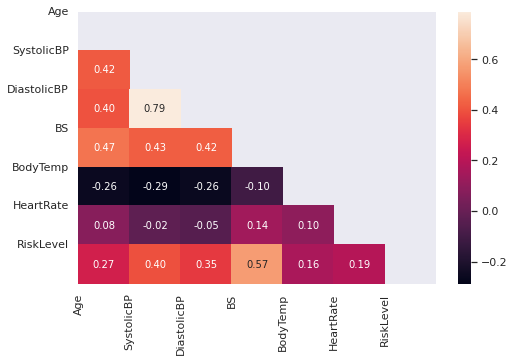

In [19]:
corr = df.corr()
#mask the repeated  values
mask = np.zeros_like(corr,dtype=bool);
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 5));
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, annot=True, fmt=".2f" , mask=mask,);
    #Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns);
    #show plot
plt.show()

## 3.2.2 Feature Importance

[0.01842722 0.04339839 0.02847327 0.07436588 0.01741236 0.01212548
 0.80579739]


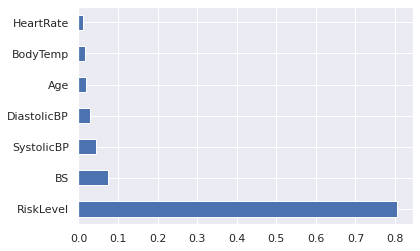

In [20]:
X = df.iloc[:,0:20]  #independent columns
y = df.iloc[:,-1]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## 3.2.3 Pairplot

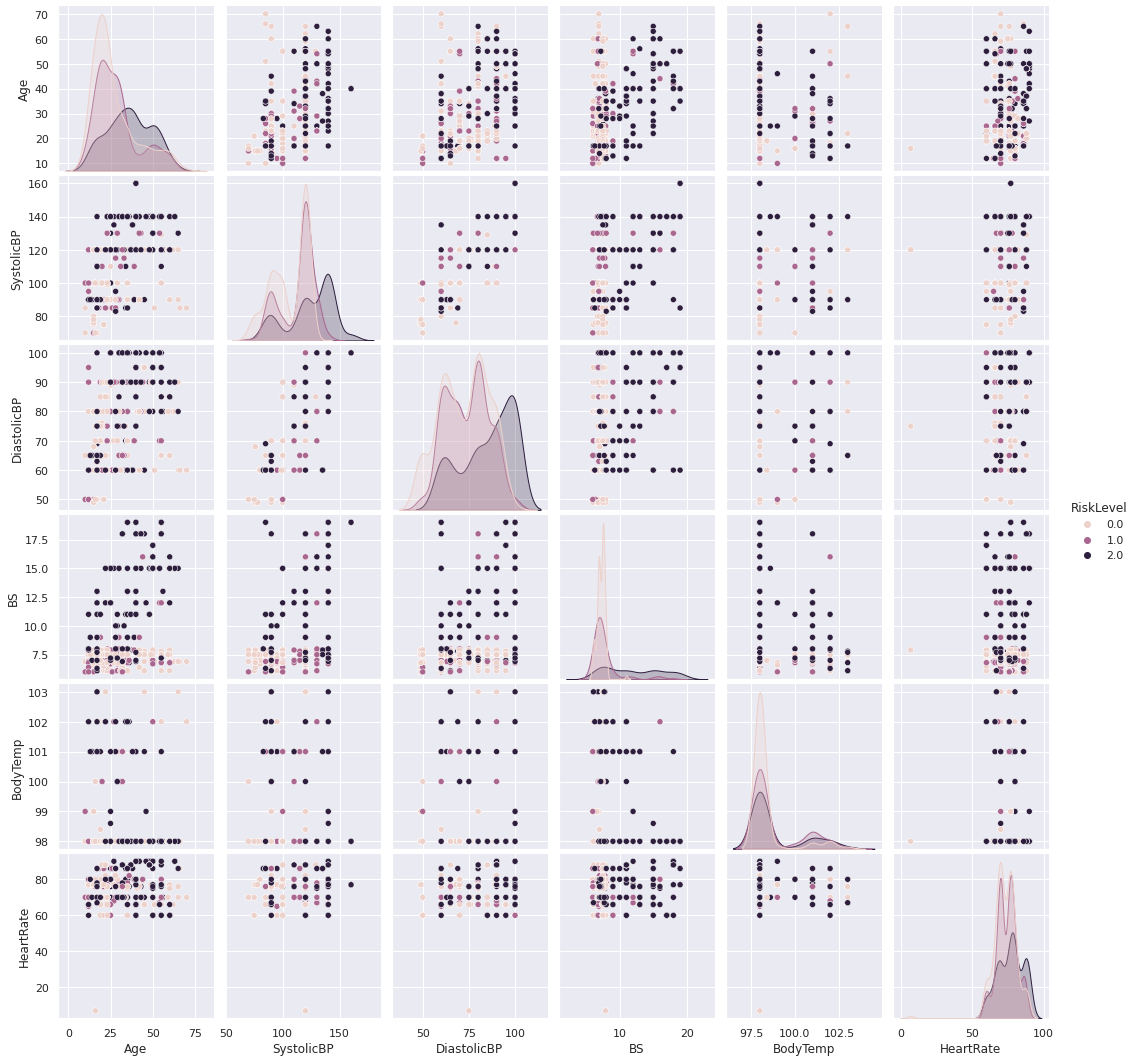

In [21]:
sns.pairplot(df, hue='RiskLevel')

# 4. Feature Engineering

## 4.1 Removing Outliers

In [22]:
df = df.drop(df.index[df.HeartRate == 7])

##4.2 Feature Selection

In [23]:
df = df.drop(["HeartRate"], axis=1)

#5. Model Training and Evaluation

## Model Selection

In [24]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm, model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, neural_network
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, auc,roc_curve, roc_auc_score, classification_report
from sklearn.naive_bayes import GaussianNB

In [25]:
X = df.drop('RiskLevel', axis=1)
y = df[['RiskLevel']]
y = y.values.ravel()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [27]:
clf = [
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.RandomForestClassifier(),
    naive_bayes.GaussianNB(),
    CalibratedClassifierCV(svm.LinearSVC()), # SVC does not have predict_proba, and is wrapped into CalibratedClassifierCV
    tree.DecisionTreeClassifier(),
    XGBClassifier(),
    KNeighborsClassifier()
    ]

In [28]:
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)

row_index = 0
for alg in clf:    
    
    predicted = alg.fit(X_train, y_train).predict(X_test)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index,'Classifier'] = clf_name;
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 4);
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 4);
    row_index+=1
    
clf_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)  
clf_compare

,Classifier,Train Accuracy,Test Accuracy
1,BaggingClassifier,0.9209,0.8142
5,DecisionTreeClassifier,0.9302,0.8103
2,RandomForestClassifier,0.9302,0.8024
6,XGBClassifier,0.8261,0.7312
0,AdaBoostClassifier,0.6785,0.6957
7,KNeighborsClassifier,0.8090,0.6838
4,CalibratedClassifierCV,0.6008,0.6166
3,GaussianNB,0.6074,0.5968


## 5.1 RandomForestClassifier

In [29]:
X = df.drop("RiskLevel", axis=1)
y = df.RiskLevel
x_train, x_test, y_train, y_test = split(X, y, test_size=0.2, random_state=1)

print(f"Processes data has {x_train.shape[0]} train data and {x_test.shape[0]} test data")

Processes data has 809 train data and 203 test data


In [30]:
#Base Model Accuracy
rf = RandomForestClassifier(random_state=100)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(f"Base Model Accuracy: {accuracy_score(y_test, y_pred)}")


Base Model Accuracy: 0.8916256157635468


##5.2 Hyperparameter Tuning

In [31]:
params = {
    "n_estimators": [10, 20, 50, 100],
    "criterion": ["gini", "entropy"]
}
rf = RandomForestClassifier(random_state=100)
grid = GridSearchCV(rf, params, cv=10)
grid.fit(x_train, y_train)
print("Best hyperparameter:", grid.best_params_)

Best hyperparameter: {'criterion': 'gini', 'n_estimators': 50}


In [32]:
y_pred = grid.predict(x_test)

In [33]:
print(f"Parameterized model accuracy: {accuracy_score(y_test, y_pred)}")

Parameterized model accuracy: 0.9014778325123153


In [34]:
y_pred[0], x_test.iloc[0,:]

(0.0, Age             42.0
 SystolicBP     120.0
 DiastolicBP     80.0
 BS               7.5
 BodyTemp        98.0
 Name: 953, dtype: float64)

In [35]:
grid.predict([[42,120,90,60,30]])

array([2.])

# Dumping Model for deployment

In [36]:
import pickle

In [ ]:
A, SB, DB, BS, BT = [int(x) for x in input("Enter the Age, SB(70-160), DB(49-199), BS(6-19) and BT(98-103) ").split(",")]
print(f"Age: {A}")
print(f"SystolicBP: {SB}")
print(f"DiastolicBP: {DB}")
print(f"Blood sugarBS: {BS}")
print(f"Body Temperature: {BT}")
print(f"RiskLevel: {grid.predict([[A,SB,DB,BS,BT]])}")


In [ ]:
pickle.dump(grid, open('grid.pkl','wb'))